In [23]:
import pandas as pd
import arcgis
from arcgis.gis import GIS
from datetime import datetime
from IPython.display import HTML
from matplotlib import pyplot as plt
#gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
#gis = GIS("home") #when run in Online
#gis = GIS("Pro") # when run in Pro
#gis = GIS('URL', 'User', 'pass_or_skip to ask for') #with full authentication in Notebook
#gis = GIS(profile="your_online_profile")

<Item title:"Sentinel-2 Level-2A" type:Imagery Layer owner:esri_imagery>
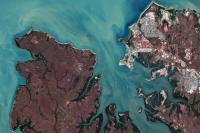

In [2]:
sentinel_item=gis.content.search('255af1ceee844d6da8ef8440c8f90d00', 'Imagery Layer', outside_org=True)[0]
sentinel_item

In [3]:
HTML(sentinel_item.description)

Band,Description,Wavelength (µm),Resolution (m)
1,Coastal aerosol,0.433 - 0.453,60
2,Blue,0.458 - 0.523,10
3,Green,0.543 - 0.578,10
4,Red,0.650 - 0.680,10
5,Vegetation Red Edge,0.698 - 0.713,20
6,Vegetation Red Edge,0.733 - 0.748,20
7,Vegetation Red Edge,0.773 - 0.793,20
8,NIR,0.785 - 0.900,10
8A,Narrow NIR,0.855 - 0.875,20
9,Water vapour,0.935 - 0.955,60


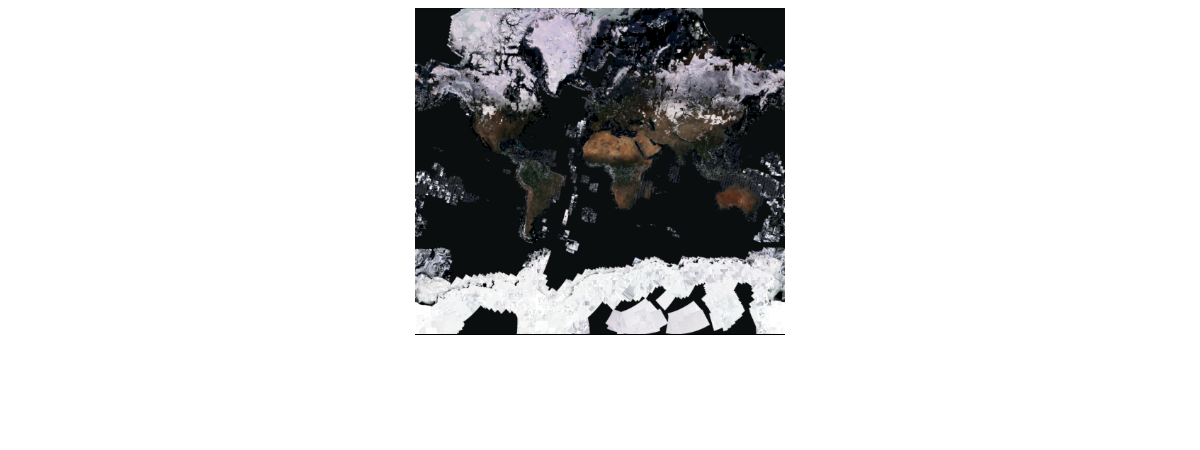

In [4]:
s2_layer=sentinel_item.layers[0]
s2_layer

## Apply built-in raster functions
The multispectral imagery layer can be rendered using several different raster functions (also known as raster function templates). Each raster function template incorporates different satellite bands to highlight different land cover features. Obtain list of predefined raster function templates defined by the service backing the imagery layer:

In [5]:
for rasterfunc in s2_layer.properties.rasterFunctionInfos:
    print(rasterfunc.name)

Natural Color with DRA
Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Short-wave Infrared with DRA
Geology with DRA
Natural Color
Agriculture
Bathymetric
Geology
Short-wave Infrared
Color Infrared
NDVI Colormap
NDMI Colorized
Normalized Burn Ratio
Normalized Difference Built-Up Index (NDBI)
NDVI Raw
NDVI - VRE only Raw
NDVI - with VRE Raw
NDWI Raw
NDWI - with VRE Raw
Scene Classification Map
WaterVapourMap
Aerosol Optical Thickness Map
None


In [7]:
from arcgis.raster.functions import apply
color_infrared = apply(s2_layer, 'Color Infrared with DRA')

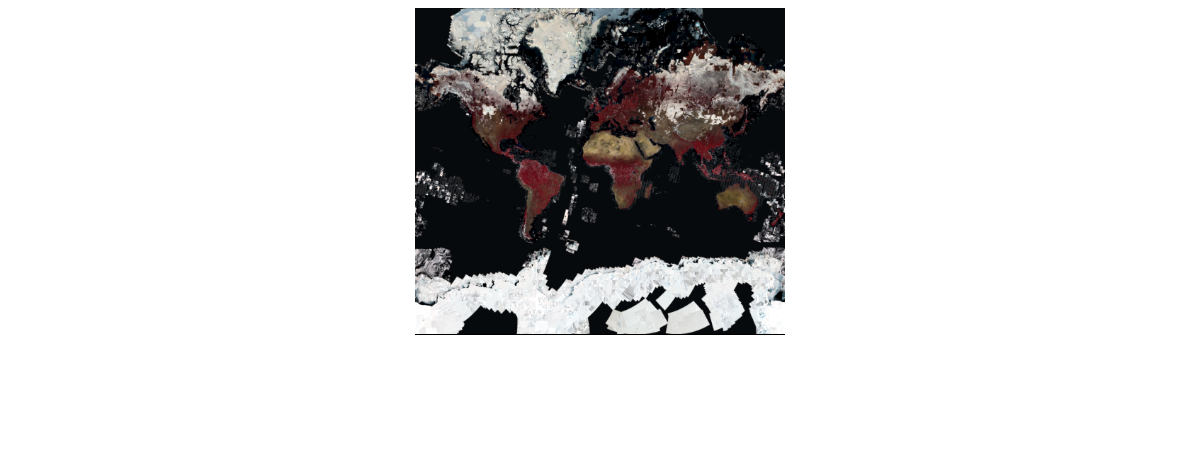

In [8]:
color_infrared

### Let's focus on some place(name)


In [9]:
from arcgis.geocoding import geocode
placename='Geneva'
area = geocode(placename, out_sr=s2_layer.properties.spatialReference)[0]

In [10]:
color_infrared.extent = area['extent']
s2_layer.extent = area['extent']

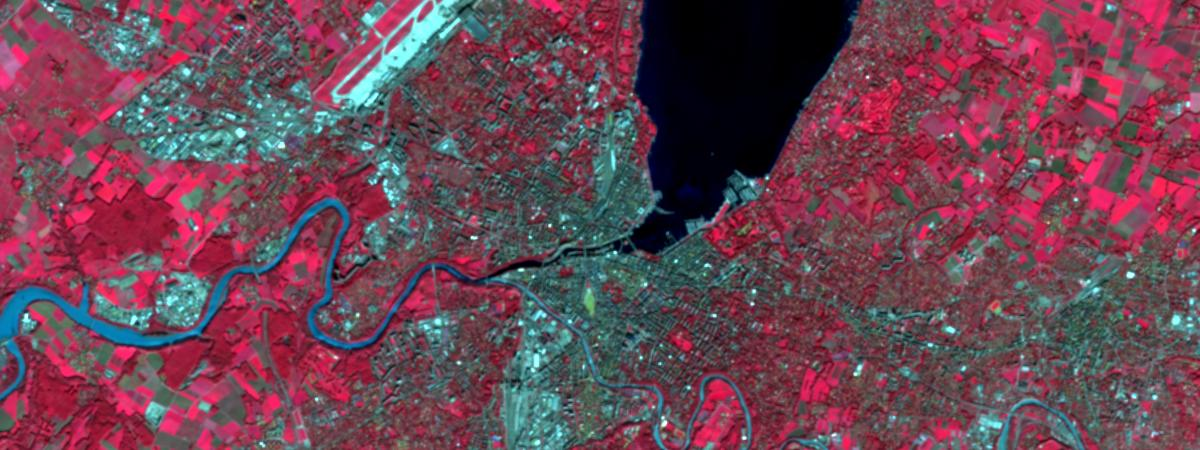

In [11]:
color_infrared

## Exporting Images from Imagery Layer
In addition to visualizing the imagery layers in the Jupyter Notebook, or using a map widge, they can be exported using the export_image method provided by ImageryLayers:

In [ ]:
from IPython.display import Image
savedimg = s2_layer.export_image(bbox=area['extent'], size=[2400,850], f='image', save_folder='.', save_file='S2_img.jpg')
savedimg


## Select images by where clause, geometry and time range
You can select images by attributes using a where clause as well as using spatial and temporal filters, using the filter_by method.

The code snippet below limits the images available to those that have less than a variable given cloud cover (default 10%), are the original images (category 1), intersect with our area of interest AND fall within a predefined timeframe:

In [12]:
#specify cloud cover in % as fraction of 1
cloud_max=0.10
#specify start date as a string of type YYYYMMDD
start_date='20210401'
#specify end date as a string of type YYYYMMDD
end_date='20220701'
start_datetime=datetime(int(start_date[:4]),int(start_date[4:6]),int(start_date[6:]))
end_datetime=datetime(int(end_date[:4]),int(end_date[4:6]),int(end_date[6:]))
selected = s2_layer.filter_by(where="(Category = 1) AND (CloudCover <="+str(cloud_max)+")", time=[start_datetime, end_datetime],geometry=arcgis.geometry.filters.intersects(area['extent']))

In [13]:
#Sentinel
fs = selected.query(out_fields="acquisitiondate, objectid, name, CloudCover, Category", 
              return_geometry=True,
              return_distinct_values=False,
              order_by_fields="AcquisitionDate")

In [14]:
df = fs.sdf
df
#display(HTML(df.to_html()))

,acquisitiondate,objectid,name,cloudcover,category,SHAPE
0,2021-04-02 10:40:21,22545065,S2A_MSIL2A_20210402T104021_N0300_R008_T31TGM_2...,0.010267,1,"{""rings"": [[[710659.3084000014, 5792025.959399..."
1,2021-04-04 10:25:59,22668879,S2B_MSIL2A_20210404T102559_N0300_R108_T31TGM_2...,0.008825,1,"{""rings"": [[[782777.1851000004, 5854535.002800..."
2,2021-04-24 10:25:49,20566879,S2B_MSIL2A_20210424T102549_N0212_R108_T31TGM_2...,0.056946,1,"{""rings"": [[[782777.1851000004, 5854535.002800..."
3,2021-06-11 10:40:21,21143501,S2A_MSIL2A_20210611T104021_N0300_R008_T31TGM_2...,0.057747,1,"{""rings"": [[[712203.4089000002, 5795459.332599..."
4,2021-06-13 10:25:59,21154272,S2B_MSIL2A_20210613T102559_N0300_R108_T31TGM_2...,0.019891,1,"{""rings"": [[[782777.1851000004, 5854535.002800..."
5,2021-06-16 10:36:29,21104919,S2B_MSIL2A_20210616T103629_N0212_R008_T31TGM_2...,0.039759,1,"{""rings"": [[[728826.2008000016, 5855248.304099..."
6,2021-07-18 10:30:31,21520927,S2A_MSIL2A_20210718T103031_N0300_R108_T31TGM_2...,0.035863,1,"{""rings"": [[[782777.1851000004, 5854535.002800..."
7,2021-08-10 10:40:31,22851235,S2A_MSIL2A_20210810T104031_N0300_R008_T31TGM_2...,0.054510,1,"{""rings"": [[[711756.2831999995, 5795585.297499..."
8,2021-08-12 10:25:59,22882401,S2B_MSIL2A_20210812T102559_N0300_R108_T31TGM_2...,0.005291,1,"{""rings"": [[[782777.1851000004, 5854535.002800..."
9,2021-09-01 10:25:59,23130234,S2B_MSIL2A_20210901T102559_N0300_R108_T31TGM_2...,0.023695,1,"{""rings"": [[[782777.1851000004, 5854535.002800..."


### Change Detection
It's quite common to compare images of the same area from two different times. The example below selects and old and a rather new images using the filter_by() method ans specifying an object id. The object id can be obtained from the query() method described above. Here we use a dataset from June2021 and one from May 2022

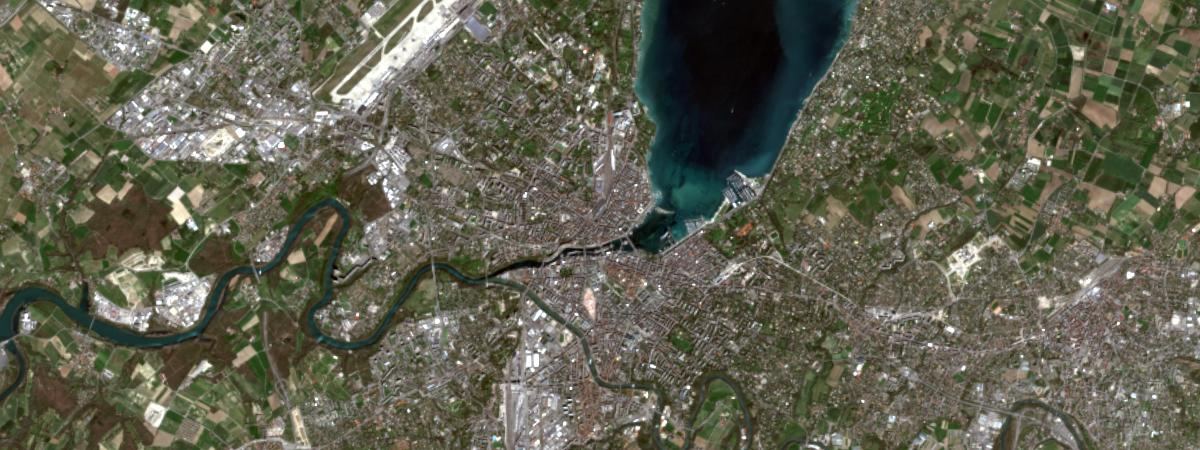

In [18]:
#April 
old = s2_layer.filter_by('OBJECTID=22668879')
#june
#old = s2_layer.filter_by('OBJECTID=21104919')
old

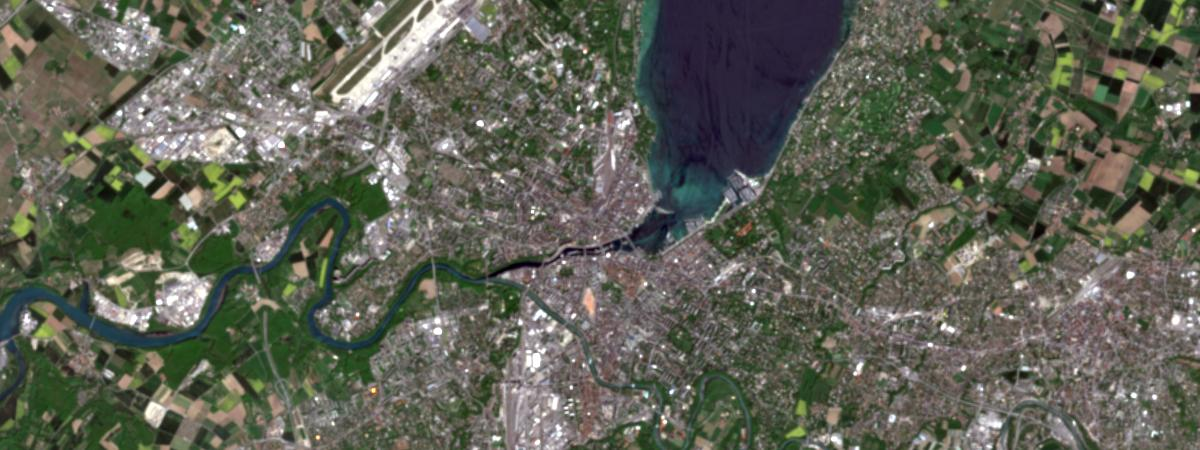

In [19]:
new = s2_layer.filter_by('OBJECTID=25655719')
#june 
#new = s2_layer.filter_by('OBJECTID=26408599')
new

### Difference Image
Difference Image mode illustrates all the changes in NDVI (vegeration index) between the two dates:

increases are shown in green, and decreases are shown in magenta.

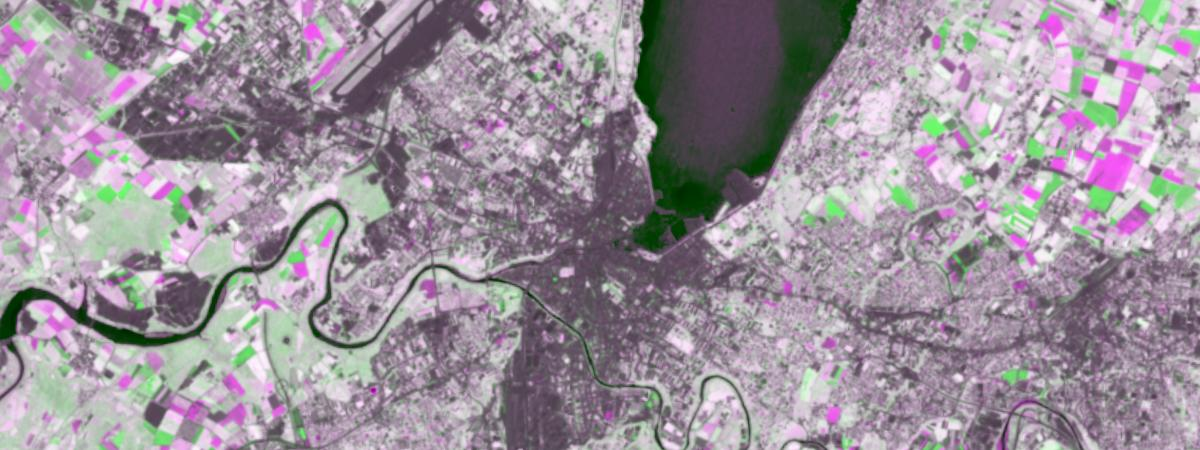

In [20]:
from arcgis.raster.functions import *
#use bands 8 and 4 for Sentinel
ndvi_current=ndvi(new, '8 4')
ndvi_old=ndvi(old, '8 4')
diff = stretch(composite_band([ndvi(old, '8 4'),
                               ndvi(new, '8 4'),
                               ndvi(old, '8 4')]), 
                               stretch_type='stddev',  num_stddev=3, min=0, max=255, dra=True, astype='u8')
diff

The difference can also be computed using map algebra, as shown below:


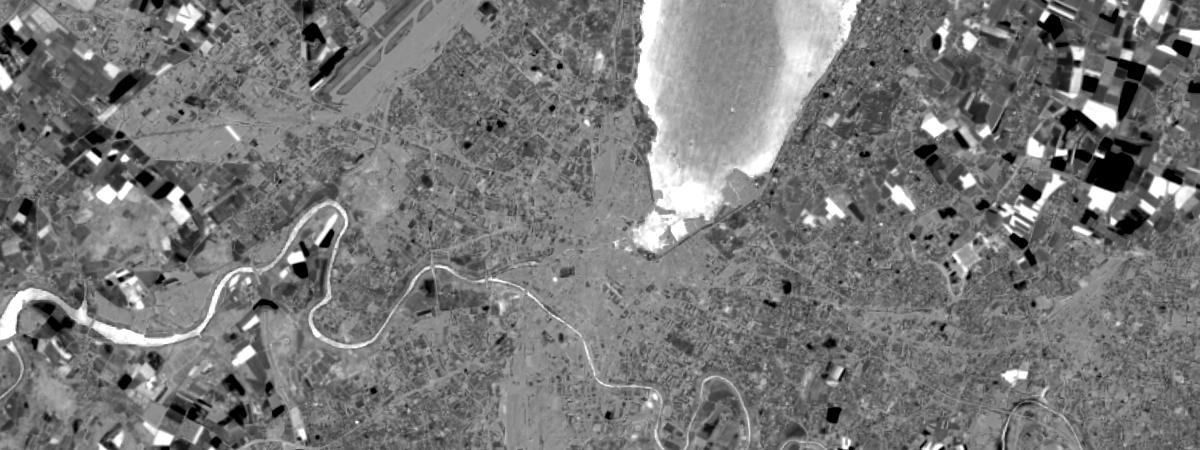

In [22]:
ndvi_diff = ndvi(new, '8 4') - ndvi(old, '8 4')
ndvi_diff

The example below renders the areas where the change is above the specified threshold and renders it using a green color:

In [21]:
from IPython.display import Image
threshold_val = 0.1
masked = colormap(remap(ndvi_diff, 
                        input_ranges=[threshold_val, 1], 
                        output_values=[1], 
                        no_data_ranges=[-1, threshold_val], astype='u8'), 
                  colormap=[[1, 124, 252, 0]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

NameError: name 'ndvi_diff' is not defined

### How green is my selected location ?

"remap" function is used to define the NDVI range for agricultural land and forest. The NDVI values between 0.4 - 0.5 represents agricultural land whereas NDVI values between 0.5 - 1 shows forest/ tree cover [2].

In [ ]:
threshold_val = 0.5
masked = colormap(remap(ndvi_current, 
                        input_ranges=[0.4,threshold_val,     # agricultural land
                                     threshold_val, 1],      # forest area/ tree cover
                        output_values=[1, 2]),
                        colormap=[[1, 124, 252, 0], [2, 0, 102, 0]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

In [ ]:
pixx = (new.extent['xmax'] - new.extent['xmin']) / 1200
pixy = (new.extent['ymax'] - new.extent['ymin']) / 450

res = masked.compute_histograms(new.extent,
                               pixel_size={'x':pixx, 'y':pixy})
numpix = 0
histogram = res['histograms'][0]['counts'][0:]
for i in histogram[1:]:
    numpix += i
histogram


In [ ]:
from matplotlib import pyplot as plt
plt.title('Green Cover', y=-0.1)
plt.pie(histogram, labels=['Non green','Agricultural Land', 'Forest Cover']);
plt.axis('equal');
plt.show()

In [ ]:
from ipywidgets import *
import pandas as pd
#or do a side by side
#assign different situations to 3 maps
m1 = gis.map(placename, 11)
m1.add_layer(ndvi_current)
m2 = gis.map(placename, 11)
m2.add_layer(ndvi_old)
m3 = gis.map(placename, 11)
m3.add_layer(diff)
#set defaults for display
pad='6px'
fl='1 1'
hgt='300px'
#and grid the output side by side
m1.layout=Layout(flex=fl, padding=pad, height=hgt)
m2.layout=Layout(flex=fl, padding=pad, height=hgt)
m3.layout=Layout(flex=fl, padding=pad, height=hgt)
box = HBox([m1, m2, m3])
box